In [16]:
# 使用するパッケージの宣言
%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt

Traceback (most recent call last):
  File "C:\Users\snmme\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 196, in process
    func(*args, **kwargs)
  File "C:\Users\snmme\anaconda3\lib\site-packages\matplotlib\animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


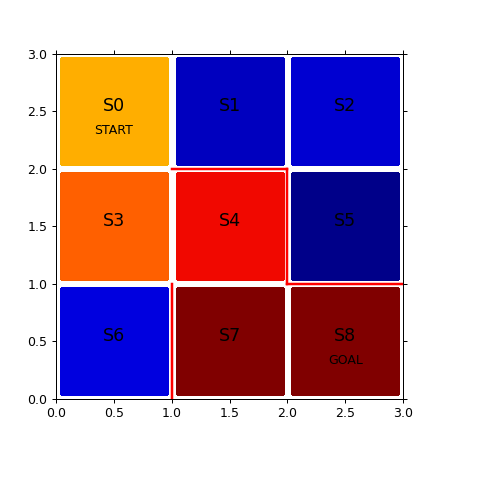

In [17]:
# 初期位置での迷路の様子b

# 図を描く大きさと、図の変数名を宣言
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

# 赤い壁を描く
plt.plot([1,1],[0,1],color='red',linewidth=2)
plt.plot([1,2],[2,2],color='red',linewidth=2)
plt.plot([2,2],[2,1],color='red',linewidth=2)
plt.plot([2,3],[1,1],color='red',linewidth=2)

# 状態を示す文字50~58を描く
plt.text(0.5, 2.5, 'S0',size=14,ha='center')
plt.text(1.5, 2.5, 'S1',size=14,ha='center')
plt.text(2.5, 2.5, 'S2',size=14,ha='center')
plt.text(0.5, 1.5, 'S3',size=14,ha='center')
plt.text(1.5, 1.5, 'S4',size=14,ha='center')
plt.text(2.5, 1.5, 'S5',size=14,ha='center')
plt.text(0.5, 0.5, 'S6',size=14,ha='center')
plt.text(1.5, 0.5, 'S7',size=14,ha='center')
plt.text(2.5, 0.5, 'S8',size=14,ha='center')
plt.text(0.5, 2.3, 'START',ha='center')
plt.text(2.5, 0.3, 'GOAL',ha='center')

# 描画画面の設定とメモリを消す設定
ax.set_xlim(0,3)
ax.set_ylim(0,3)
plt.tick_params(axis='both',which='both',bottom='off',top='off',
labelbottom='off',right='off',left='off',labelleft='off')

# 現在地S0に緑丸を描画
line, = ax.plot([0.5], [2.5], marker="o",color='g',markersize=60)
# plt.show()

In [18]:
# 初期の方策を決定するパラメータtheta_0を設定

# 行は状態0~7、列は移動方向で、上、右、下、左を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan], # S0
                    [np.nan, 1, np.nan, 1], # S1
                    [np.nan, np.nan, 1, 1], # S2
                    [1, 1, 1, np.nan], # S3
                    [np.nan, np.nan, 1, 1], # S4
                    [1, np.nan, np.nan, np.nan], # S5
                    [1, np.nan, np.nan, np.nan], # S6
                    [1, 1, np.nan, np.nan], # S7
                    ])


In [19]:
# 初期の行動価値関数Qを設定

[a,b]=theta_0.shape # 行と列の数をa,bに格納
Q=np.random.rand(a,b)*theta_0*0.1
# *theta0をすることで要素ごとに掛け算をし、Qの壁方向の値がnanになる

In [20]:
# 方策パラメータtheta_0をランダム方策piに変換する関数の定義

def simple_convert_into_pi_from_theta(theta):
    '''単純に割合を計算する'''
    
    [m,n]=theta.shape # thetaの行列サイズを取得
    pi=np.zeros((m,n))
    for i in range(0,m):
        pi[i,:] = theta[i,:]/np.nansum(theta[i,:]) # 割合の計算
        
    pi = np.nan_to_num(pi) # nanを0に変換
    
    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [21]:
# 1step移動後の状態sを求める関数を定義

def get_action(s, Q, epsilon, pi_0):
    direction = ["up","right","down","left"]
    
    if np.random.rand()<epsilon:
        # εの確立でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s,:])]
 
    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action=1
    elif next_direction == "down":
        action=2
    elif next_direction == "left":
        action = 3

    return action

def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up","right","down","left"]
    next_direction=direction[a]
    
    if next_direction == "up":
        s_next = s-3 # 上に移動するときは状態の数字が3小さくなる
    elif next_direction == "right":
        s_next = s+1 # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s+3 # 下に移動するときは状態の数字が3大きくなる
    elif next_direction == "left":
        s_next = s-1 #左に移動するときは状態の数字が１小さくなる
        
    return s_next

In [22]:
# Q学習による行動価値関数Qの更新

def Q_learning(s,a,r,s_next,a_next,Q,eta,gamma):
    
    if s_next == 8: #ゴールした場合
        Q[s,a] = Q[s,a]+eta*(r-Q[s,a])
        
    else:
        Q[s,a]=Q[s,a]+eta*(r+gamma*np.nanmax(Q[s_next, a_next])-Q[s,a])
        
    return Q

In [23]:
# 迷路内をエージェントがゴールするまで移動させる関数の定義
def goal_maze_ret_s_a_Q(Q,epsion,eta,gamma,pi):
    s=0 # スタート地点
    a=a_next=get_action(s,Q,epsilon,pi) # 初期の行動
    s_a_history = [[0, np.nan]] #エージェントの移動を記録するリスト

    while(1): # ゴールするまでループする
        a=a_next # 行動更新
        s_a_history[-1][1] = a
        # 現在の状態（つまり一番最後なのでindex=-1)の行動を代入
        
        s_next = get_s_next(s,a,Q,epsilon,pi)
        # 次の状態を格納
        
        s_a_history.append([s_next, np.nan])
        # 次の状態を代入。行動はまだわからないのでnanにしておく
        
        # 報酬を与え、次の行動を求める
        if s_next == 8: 
            r = 1 #ゴールにたどりついたら報酬を与える
            a_next = np.nan
        else:
            r=0
            a_next = get_action(s_next,Q,epsilon,pi)
            
        # 価値関数を更新
        Q = Q_learning(s,a,r,s_next,a_next,Q,eta,gamma)
    
        # 終了判定
        if s_next == 8: # ゴール地点なら終了
            break
        else:
            s = s_next
    
    return [s_a_history,Q]

In [24]:
# Q学習で迷路を解く

eta=0.1 # 学習率
gamma = 0.9 # 時間割引率
epsilon = 0.5 # ε-greedy手法の初期値
v=np.nanmax(Q, axis=1) # 状態ごとに価値の最大値を求める
is_continue = True
episode=1

V = [] # エピソードごとの状態価値を格納する
V.append(np.nanmax(Q,axis=1)) # 状態ごとに行動価値の最大値を求める

while is_continue: #is_continueがFlaseになるまで繰り返す
    print("エピソード:" + str(episode))
    
    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon/2
    
    # Q学習で迷路を解き、移動した履歴と更新したQを求める
    [s_a_history,Q]=goal_maze_ret_s_a_Q(Q,epsilon,eta,gamma,pi_0)
    
    # 状態価値の変化
    new_v = np.nanmax(Q,axis=1) #状態ごとに価値の最大値を求める
    print(np.sum(np.abs(new_v-v))) # 状態価値の変化を出力
    v = new_v
    V.append(v) # このエピソード終了時の状態価値関数を追加
    
    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history)-1)+"です")
    
    # 100エピソード繰り返す
    episode = episode +1
    if episode > 100:
        break

エピソード:1
0.12279033311877151
迷路を解くのにかかったステップ数は20です
エピソード:2
0.09427765770164773
迷路を解くのにかかったステップ数は4です
エピソード:3
0.09302884973721717
迷路を解くのにかかったステップ数は4です
エピソード:4
0.09181725938758235
迷路を解くのにかかったステップ数は4です
エピソード:5
0.09063426011058173
迷路を解くのにかかったステップ数は4です
エピソード:6
0.08946801039011809
迷路を解くのにかかったステップ数は4です
エピソード:7
0.08830523332859998
迷路を解くのにかかったステップ数は4です
エピソード:8
0.08713250808524942
迷路を解くのにかかったステップ数は4です
エピソード:9
0.0859371753689339
迷路を解くのにかかったステップ数は4です
エピソード:10
0.08470794080309056
迷路を解くのにかかったステップ数は4です
エピソード:11
0.08343524458780059
迷路を解くのにかかったステップ数は4です
エピソード:12
0.08211145303414065
迷路を解くのにかかったステップ数は4です
エピソード:13
0.0807309168484504
迷路を解くのにかかったステップ数は4です
エピソード:14
0.0792899321656165
迷路を解くのにかかったステップ数は4です
エピソード:15
0.07778663298624851
迷路を解くのにかかったステップ数は4です
エピソード:16
0.07622083761998034
迷路を解くのにかかったステップ数は4です
エピソード:17
0.0745938667694308
迷路を解くのにかかったステップ数は4です
エピソード:18
0.07290834683088615
迷路を解くのにかかったステップ数は4です
エピソード:19
0.07116800868934134
迷路を解くのにかかったステップ数は4です
エピソード:20
0.06937748962071327
迷路を解くのにかかったステップ数は4です
エピソード:21
0.0

In [25]:
# 状態価値の変化の様子の可視化
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm # color map

def init():
    '''背景画像の初期化'''
    line.set_data([], [])
    return(line,)

def animate(i):
    # フレームごとの描画内容
    # 各マスに状態価値の大きさに基づく色付きの四角を描画
    line, = ax.plot([0.5],[2.5],marker="s",color=cm.jet(V[i][0]),markersize=85) # S0
    line, = ax.plot([1.5],[2.5],marker="s",color=cm.jet(V[i][1]),markersize=85) # S1
    line, = ax.plot([2.5],[2.5],marker="s",color=cm.jet(V[i][2]),markersize=85) # S2
    line, = ax.plot([0.5],[1.5],marker="s",color=cm.jet(V[i][3]),markersize=85) # S3
    line, = ax.plot([1.5],[1.5],marker="s",color=cm.jet(V[i][4]),markersize=85) # S4
    line, = ax.plot([2.5],[1.5],marker="s",color=cm.jet(V[i][5]),markersize=85) # S5
    line, = ax.plot([0.5],[0.5],marker="s",color=cm.jet(V[i][6]),markersize=85) # S6
    line, = ax.plot([1.5],[0.5],marker="s",color=cm.jet(V[i][7]),markersize=85) # S7
    line, = ax.plot([2.5],[0.5],marker="s",color=cm.jet(1.0),markersize=85) # S0
    return(line,)

# 初期化関数とフレームごとの描画関数を用いて動画を作成する
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(V), interval=200,repeat=False)

HTML(anim.to_jshtml())

In [15]:
V

[array([0.72392254, 0.02542197, 0.02538317, 0.80861035, 0.89974651,
        0.02534531, 0.03285285, 0.99997692]),
 array([0.72430522, 0.02542197, 0.02538317, 0.8087265 , 0.89976978,
        0.02534531, 0.03285285, 0.99997923]),
 array([0.72466008, 0.02542197, 0.02538317, 0.80883313, 0.89979093,
        0.02534531, 0.03285285, 0.9999813 ]),
 array([0.72498905, 0.02542197, 0.02538317, 0.808931  , 0.89981016,
        0.02534531, 0.03285285, 0.99998317]),
 array([0.72529394, 0.02542197, 0.02538317, 0.80902082, 0.89982763,
        0.02534531, 0.03285285, 0.99998486]),
 array([0.72557642, 0.02542197, 0.02538317, 0.80910322, 0.8998435 ,
        0.02534531, 0.03285285, 0.99998637]),
 array([0.72583807, 0.02542197, 0.02538317, 0.80917881, 0.89985793,
        0.02534531, 0.03285285, 0.99998773]),
 array([0.72608035, 0.02542197, 0.02538317, 0.80924815, 0.89987103,
        0.02534531, 0.03285285, 0.99998896]),
 array([0.72630465, 0.02542197, 0.02538317, 0.80931172, 0.89988293,
        0.02534531, 